# Setup

In [ ]:
# %load init_setup/setup.py
# ==- INITIAL SETUP -===============================================================================
import math
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets

np.set_printoptions(formatter={'float': '{: 0.5f}'.format}, suppress = True)
matplotlib.rcParams.update({'font.size': 16})

# ==- PLOT PARAMETERS -=============================================================================
loglogalpha = 0.70
baralpha    = 0.85

plot_size = (14,8)
subplot_size = (7,4)

# ==- COLOR PALETTE -===============================================================================
c_red = "#e6194b" # red
c_gre = "#3cb44b" # green
c_yel = "#ffe119" # yellow
c_blu = "#4363d8" # blue
c_ora = "#f58231" # orange
c_pur = "#911eb4" # purple
c_cya = "#42d4f4" # cyan
c_mag = "#f032e6" # magenta
c_lim = "#bfef45" # lime
c_pin = "#fabebe" # pink
c_tea = "#469990" # teal
c_lav = "#e6beff" # lavender
c_bro = "#9A6324" # brown
c_bei = "#fffac8" # beige
c_mar = "#800000" # maroon
c_min = "#aaffc3" # mint
c_oli = "#808000" # olive
c_apr = "#ffd8b1" # apricot
c_nav = "#000075" # navy
c_gra = "#a9a9a9" # gray
c_whi = "#ffffff" # white
c_bla = "#000000" # black

accessibility_95    = [c_red, c_gre, c_blu, c_yel, c_ora, c_pur, c_cya,
                       c_mag, c_lim, c_pin, c_tea, c_lav, c_bro, c_bei,
                       c_mar, c_min, c_oli, c_apr, c_nav, c_gra, c_bla]
accessibility_99    = [c_red, c_gre, c_blu, c_yel, c_ora, c_cya, c_mag,
                       c_pin, c_tea, c_lav, c_bro, c_bei, c_mar, c_min,
                       c_nav, c_gra, c_bla]
accessibility_99_99 = [c_blu, c_yel, c_ora, c_pin, c_lav, c_mar, c_nav,
                       c_gra, c_bla]
accessibility_100   = [c_blu, c_yel, c_gra, c_bla]


In [ ]:
# %load init_setup/setup2.py
matplotlib.rcParams.update({'font.size': 16})


# File Reading

In [3]:
def read_file(filename):
    arr = []
    
    f = open(filename, 'r')
    for line in f:
        arr.append(float(line.replace("\n", "")))
    f.close()
    return np.array(arr)

def read_sv_file(filename):
    first_line = True
    sv = []
    
    f = open(filename, 'r')
    for line in f:
        if first_line:
            first_line = False
            continue
        sv = list(filter(None, line.replace("\n", "").split(' ')))
        for i in range(len(sv)):
            sv[i] = float(sv[i])
    f.close()
    return np.array(sv)

def read_cm_file(filename):
    first_line = True
    cm = []
    
    f = open(filename, 'r')
    for line in f:
        if first_line:
            first_line = False
            continue
        cm_tmp = list(filter(None, line.replace("\n", "").split(' ')))
        for i in range(len(cm_tmp)):
            cm_tmp[i] = float(cm_tmp[i])
        cm.append(cm_tmp)
    f.close()
    return np.array(cm)

def read_Z_file(filename):
    first_line = True
    Z = []
    
    f = open(filename, 'r')
    for line in f:
        if first_line:
            first_line = False
            continue
        Z.append(float(line.replace("\n", "")))
    f.close()
    return np.array(Z)

def read_meas_file(filename):
    first_line = True
    m = []
    
    f = open(filename, "r")
    for line in f:
        if first_line:
            first_line = False
            continue
        meas = line.replace("\n", "").split(' ')
        meas = list(filter(None, meas))
        for i in range(len(meas)):
            meas[i] = float(meas[i])
        m.append([meas[0], meas[1], meas[2], meas[3], meas[4], meas[5], meas[6]])
    f.close()
    return m

# Reads a magnetic fields file and returns an array with a [x,y,z] mesh grid and the [bx,by,bz] magfields 
#     measurements.
def unpack_magfield_file(filename):
    B = [[], [], [], [], [], []]
    f = open(filename, "r")
    
    for line in f:
        mag_meas = line.replace("\n", "").split(' ')
        mag_meas = list(filter(None, mag_meas))
        for i in range(len(mag_meas)):
            mag_meas[i] = float(mag_meas[i])
        if mag_meas[0] not in B[0]:
            B[0].append(mag_meas[0])
        if mag_meas[1] not in B[1]:
            B[1].append(mag_meas[1])
        if mag_meas[2] not in B[2]:
            B[2].append(mag_meas[2])
        B[3].append(mag_meas[3])
        B[4].append(mag_meas[4])
        B[5].append(mag_meas[5])

    f.close()
    
    return B

# Packs an array into an array of dest_size sized arrays.
def pack_data(src_arr, dest_size):
    dest_arr = []
    it       = 0
    for d in src_arr:
        if it == 0:
            dest_arr.append([d])
        else:
            dest_arr[-1].append(d)
        it += 1
        if it == dest_size:
            it = 0
    return dest_arr

# Magnetic Field Estimation

In [4]:
# Create interpolators for bx, by and bz based on a set of magnetic field measurements
def create_interpolators(x, y, z, bx, by, bz, bounds_error=True):
    bx_z = pack_data(bx, len(z))
    by_z = pack_data(by, len(z))
    bz_z = pack_data(bz, len(z))

    bx_y = np.array(pack_data(bx_z, len(y)))
    by_y = np.array(pack_data(by_z, len(y)))
    bz_y = np.array(pack_data(bz_z, len(y)))

    bx_interpolator = RegularGridInterpolator((x, y, z), bx_y, method="linear", bounds_error=bounds_error)
    by_interpolator = RegularGridInterpolator((x, y, z), by_y, method="linear", bounds_error=bounds_error)
    bz_interpolator = RegularGridInterpolator((x, y, z), bz_y, method="linear", bounds_error=bounds_error)
    
    return (bx_interpolator, by_interpolator, bz_interpolator)

# Gets the magnetic field (bx,by,bz) at a specific location l (x,y,z)
def get_b(l, B):
    return [B[0]([l[0], l[1], l[2]])[0], B[1]([l[0], l[1], l[2]])[0], B[2]([l[0], l[1], l[2]])[0]]

# Configuration

In [5]:
# file names
MASTERDIR          = "data/PKF/"
EVENTDIRS          = ["e022/", "e089/", "e096/", "e107/", "e127/"]
ZFILENAME          = "Z"
SVFILENAME         = "init_statevec"
CMFILENAME         = "init_covmat"
MEASFILENAME       = "measurements"
MAGFIELDFILENAME   = "bfield_meas_s2" # ss=10, r=[-200, 200]
JAVACHI2FILENAME   = "fchi2_java"
PYTHONCHI2FILENAME = "fchi2_python"

# constants
v    = 0.002997924580 # speed of light
mass = 0.13957018

# arrays
Z  = []
m  = []
si = []
Si = []

# prepare the Z planes and measurement arrays
for d in EVENTDIRS:
    Z.append(read_Z_file(MASTERDIR + d + ZFILENAME))
    si.append(read_sv_file(MASTERDIR + d + SVFILENAME))
    Si.append(read_cm_file(MASTERDIR + d + CMFILENAME))
    m.append(read_meas_file(MASTERDIR + d + MEASFILENAME))

# prepare the interpolators
d = unpack_magfield_file(MASTERDIR + MAGFIELDFILENAME)
B = create_interpolators(d[0], d[1], d[2], d[3], d[4], d[5], bounds_error=True)

# Kalman Filter
### Runge Kutta 4

In [6]:
# "private" methods called only by Runge Kutta 4
def Ax(tx, ty, bx, by, bz, C):
    return C * ( ty * (tx*bx + bz) - (1 + tx*tx) * by)

def Ay(tx, ty, bx, by, bz, C):
    return C * (-tx * (ty*by + bz) + (1 + ty*ty) * bx)

def delAx_deltx(tx, ty, bx, by, bz, Csq, C, Ax, Ay):
    return tx*Ax/Csq + C * (ty*bx - 2*tx*by)

def delAx_delty(tx, ty, bx, by, bz, Csq, C, Ax, Ay):
    return ty*Ax/Csq + C * (tx*bx + bz)

def delAy_deltx(tx, ty, bx, by, bz, Csq, C, Ax, Ay):
    return tx*Ay/Csq + C * (-ty*by - bz)

def delAy_delty(tx, ty, bx, by, bz, Csq, C, Ax, Ay):
    return ty*Ay/Csq + C * (-tx*by + 2*ty*bx)

def deltx_deltx0_next(qv, tx1, ty1, b0, b1, b2, deltx_deltx0_1, delty_deltx0_1, Csq, C, Ax, Ay):
    return qv * (delAx_deltx(tx1, ty1, b0, b1, b2, Csq, C, Ax, Ay) * deltx_deltx0_1
            + delAx_delty(tx1, ty1, b0, b1, b2, Csq, C, Ax, Ay) * delty_deltx0_1)

def deltx_delty0_next(qv, tx1, ty1, b0, b1, b2, deltx_delty0_1, delty_delty0_1, Csq, C, Ax, Ay):
    return qv * (delAx_deltx(tx1, ty1, b0, b1, b2, Csq, C, Ax, Ay) * deltx_delty0_1
            + delAx_delty(tx1, ty1, b0, b1, b2, Csq, C, Ax, Ay) * delty_delty0_1)

def deltx_delq0_next(qv, v, tx1, ty1, b0, b1, b2, deltx_delq0_1, delty_delq0_1, Csq, C, Ax, Ay):
    return v * Ax + qv * (delAx_deltx(tx1, ty1, b0, b1, b2, Csq, C, Ax, Ay) * deltx_delq0_1
            + delAx_delty(tx1, ty1, b0, b1, b2, Csq, C, Ax, Ay) * delty_delq0_1)

def delty_deltx0_next(qv, tx1, ty1, b0, b1, b2, deltx_deltx0_1, delty_deltx0_1, Csq, C, Ax, Ay):
    return qv * (delAy_deltx(tx1, ty1, b0, b1, b2, Csq, C, Ax, Ay) * deltx_deltx0_1
            + delAy_delty(tx1, ty1, b0, b1, b2, Csq, C, Ax, Ay) * delty_deltx0_1)

def delty_delty0_next(qv, tx1, ty1, b0, b1, b2, deltx_delty0_1, delty_delty0_1, Csq, C, Ax, Ay):
    return qv * (delAy_deltx(tx1, ty1, b0, b1, b2, Csq, C, Ax, Ay) * deltx_delty0_1
            + delAy_delty(tx1, ty1, b0, b1, b2, Csq, C, Ax, Ay) * delty_delty0_1)
                 
def delty_delq0_next(qv, v, tx1, ty1, b0, b1, b2, deltx_delq0_1, delty_delq0_1, Csq, C, Ax, Ay):
    return v * Ay + qv * (delAy_deltx(tx1, ty1, b0, b1, b2, Csq, C, Ax, Ay) * deltx_delq0_1
            + delAy_delty(tx1, ty1, b0, b1, b2, Csq, C, Ax, Ay) * delty_delq0_1)

def RK4(k1, k2, k3, k4, h):
    return h/6 * (k1 + 2*k2 + 2*k3 + k4)

In [7]:
# Runs Runge Kutta 4 transport on an initial state vector and covariance matrix si and Si with a step size of h.
# INPUT:
#   si : initial state vector
#   Si : initial covariance matrix
#   h  : step size
#   B  : magnetic field interpolators (bx, by, bz)
# OUTPUT:
#   sf : final state vector
#   Sf : final covariance matrix
def rk4_transport(si, Si, h, B):
    # Unpack the initial state vector
    z0     = si[0]
    x0     = si[1]
    y0     = si[2]
    tx0    = si[3]
    ty0    = si[4]
    q      = si[5]
    d_path = si[7]

    # Jacobian
    u = np.empty([5,5])
    Sf = np.empty([5,5])
    deltx_deltx0_0 = 1.
    deltx_delty0_0 = 0.
    deltx_delq0_0  = 0.
    delty_deltx0_0 = 0.
    delty_delty0_0 = 1.
    delty_delq0_0  = 0.

    # Auxiliary variables
    qv = q*v
    hh = 0.5*h

    # ==- K1 -=============================================================================
    b = get_b([x0, y0, z0], B)

    # Auxiliary variables
    C1sq = 1 + tx0*tx0 + ty0+ty0
    C1   = np.sqrt(C1sq)
    Ax1  = Ax(tx0, ty0, b[0], b[1], b[2], C1)
    Ay1  = Ay(tx0, ty0, b[0], b[1], b[2], C1)

    # State
    x1  = tx0
    y1  = ty0
    tx1 = qv * Ax1
    ty1 = qv * Ay1

    # Jacobian
    delx_deltx0_1 = deltx_deltx0_0
    delx_delty0_1 = deltx_delty0_0
    delx_delq0_1  = deltx_delq0_0

    dely_deltx0_1 = delty_deltx0_0
    dely_delty0_1 = delty_delty0_0
    dely_delq0_1  = delty_delq0_0

    deltx_deltx0_1 = qv * delAx_deltx(tx0, ty0, b[0], b[1], b[2], C1sq, C1, Ax1, Ay1)
    deltx_delty0_1 = qv * delAx_delty(tx0, ty0, b[0], b[1], b[2], C1sq, C1, Ax1, Ay1)
    deltx_delq0_1  = v  * Ax1

    delty_deltx0_1 = qv * delAy_deltx(tx0, ty0, b[0], b[1], b[2], C1sq, C1, Ax1, Ay1)
    delty_delty0_1 = qv * delAy_delty(tx0, ty0, b[0], b[1], b[2], C1sq, C1, Ax1, Ay1)
    delty_delq0_1  = v  * Ay1

    # ==- K2 -=============================================================================
    b = get_b([x0 + hh*x1, y0 + hh*y1, z0 + hh], B)

    # State 1
    x2 = tx0 + hh*tx1
    y2 = ty0 + hh*ty1

    # Auxiliary variables
    C2sq = 1 + x2*x2 + y2*y2
    C2   = np.sqrt(C2sq)
    Ax2  = Ax(x2, y2, b[0], b[1], b[2], C2)
    Ay2  = Ay(x2, y2, b[0], b[1], b[2], C2)

    dtxtx1 = deltx_deltx0_0 + hh*deltx_deltx0_1
    dtxty1 = deltx_delty0_0 + hh*deltx_delty0_1
    dtxtq1 = deltx_delq0_0  + hh*deltx_delq0_1
    dtytx1 = delty_deltx0_0 + hh*delty_deltx0_1
    dtyty1 = delty_delty0_0 + hh*delty_delty0_1
    dtytq1 = delty_delq0_0  + hh*delty_delq0_1

    # State 2
    tx2 = qv * Ax2
    ty2 = qv * Ay2

    # Jacobian
    delx_deltx0_2 = deltx_deltx0_0 + hh*deltx_deltx0_1
    delx_delty0_2 = deltx_delty0_0 + hh*deltx_delty0_1
    delx_delq0_2  = deltx_delq0_0  + hh*deltx_delq0_1

    dely_deltx0_2 = delty_deltx0_0 + hh*delty_deltx0_1
    dely_delty0_2 = delty_delty0_0 + hh*delty_delty0_1
    dely_delq0_2  = delty_delq0_0  + hh*delty_delq0_1

    deltx_deltx0_2 = deltx_deltx0_next(qv, x2, y2, b[0], b[1], b[2], dtxtx1, dtytx1, C2sq, C2, Ax2, Ay2)
    deltx_delty0_2 = deltx_delty0_next(qv, x2, y2, b[0], b[1], b[2], dtxty1, dtyty1, C2sq, C2, Ax2, Ay2)
    deltx_delq0_2  = deltx_delq0_next(qv, v, x2, y2, b[0], b[1], b[2], dtxtq1, dtytq1, C2sq, C2, Ax2, Ay2)

    delty_deltx0_2 = delty_deltx0_next(qv, x2, y2, b[0], b[1], b[2], dtxtx1, dtytx1, C2sq, C2, Ax2, Ay2)
    delty_delty0_2 = delty_delty0_next(qv, x2, y2, b[0], b[1], b[2], dtxty1, dtyty1, C2sq, C2, Ax2, Ay2)
    delty_delq0_2  = delty_delq0_next(qv, v, x2, y2, b[0], b[1], b[2], dtxtq1, dtytq1, C2sq, C2, Ax2, Ay2)

    # ==- K3 -=============================================================================
    get_b([x0 + hh*x2, y0 + hh*y2, z0 + hh], B)

    # State 1
    x3 = tx0 + hh*tx2
    y3 = ty0 + hh*ty2

    # Auxiliary variables
    C3sq = 1 + x3*x3 + y3*y3
    C3   = np.sqrt(C3sq)
    Ax3  = Ax(x3, y3, b[0], b[1], b[2], C3)
    Ay3  = Ay(x3, y3, b[0], b[1], b[2], C3)

    dtxtx2 = deltx_deltx0_0 + hh*deltx_deltx0_2
    dtxty2 = deltx_delty0_0 + hh*deltx_delty0_2
    dtxtq2 = deltx_delq0_0  + hh*deltx_delq0_2
    dtytx2 = delty_deltx0_0 + hh*delty_deltx0_2
    dtyty2 = delty_delty0_0 + hh*delty_delty0_2
    dtytq2 = delty_delq0_0  + hh*delty_delq0_2

    # State 2
    tx3 = qv * Ax3
    ty3 = qv * Ay3

    # Jacobian
    delx_deltx0_3 = deltx_deltx0_0 + hh*deltx_deltx0_2
    delx_delty0_3 = deltx_delty0_0 + hh*deltx_delty0_2
    delx_delq0_3  = deltx_delq0_0  + hh*deltx_delq0_2

    dely_deltx0_3 = delty_deltx0_0 + hh*delty_deltx0_2
    dely_delty0_3 = delty_delty0_0 + hh*delty_delty0_2
    dely_delq0_3  = delty_delq0_0  + hh*delty_delq0_2

    deltx_deltx0_3 = deltx_deltx0_next(qv, x3, y3, b[0], b[1], b[2], dtxtx2, dtytx2, C3sq, C3, Ax3, Ay3)
    deltx_delty0_3 = deltx_delty0_next(qv, x3, y3, b[0], b[1], b[2], dtxty2, dtyty2, C3sq, C3, Ax3, Ay3)
    deltx_delq0_3  = deltx_delq0_next(qv, v, x3, y3, b[0], b[1], b[2], dtxtq2, dtytq2, C3sq, C3, Ax3, Ay3)

    delty_deltx0_3 = delty_deltx0_next(qv, x3, y3, b[0], b[1], b[2], dtxtx2, dtytx2, C3sq, C3, Ax3, Ay3)
    delty_delty0_3 = delty_delty0_next(qv, x3, y3, b[0], b[1], b[2], dtxty2, dtyty2, C3sq, C3, Ax3, Ay3)
    delty_delq0_3  = delty_delq0_next(qv,v, x3, y3, b[0], b[1], b[2], dtxtq2, dtytq2, C3sq, C3, Ax3, Ay3)

    # ==- K4 -=============================================================================
    get_b([x0 + h*x3, y0 + h*y3, z0 + h], B)

    # State 1
    x4 = tx0 + h*tx3
    y4 = ty0 + h*ty3

    # Auxiliary variables
    C4sq = 1 + x4*x4 + y4*y4
    C4   = np.sqrt(C4sq)
    Ax4  = Ax(x4, y4, b[0], b[1], b[2], C4)
    Ay4  = Ay(x4, y4, b[0], b[1], b[2], C4)

    dtxtx3 = deltx_deltx0_0 + hh*deltx_deltx0_3
    dtxty3 = deltx_delty0_0 + hh*deltx_delty0_3
    dtxtq3 = deltx_delq0_0  + hh*deltx_delq0_3
    dtytx3 = delty_deltx0_0 + hh*delty_deltx0_3
    dtyty3 = delty_delty0_0 + hh*delty_delty0_3
    dtytq3 = delty_delq0_0  + hh*delty_delq0_3

    # State 2
    tx4 = qv * Ax4
    ty4 = qv * Ay4

    # Jacobian
    delx_deltx0_4 = deltx_deltx0_0 + h*deltx_deltx0_3
    delx_delty0_4 = deltx_delty0_0 + h*deltx_delty0_3
    delx_delq0_4  = deltx_delq0_0  + h*deltx_delq0_3

    dely_deltx0_4 = delty_deltx0_0 + h*delty_deltx0_3
    dely_delty0_4 = delty_delty0_0 + h*delty_delty0_3
    dely_delq0_4  = delty_delq0_0  + h*delty_delq0_3

    deltx_deltx0_4 = deltx_deltx0_next(qv,  x4, y4, b[0], b[1], b[2], dtxtx3, dtytx3, C4sq, C4, Ax4, Ay4)
    deltx_delty0_4 = deltx_delty0_next(qv,  x4, y4, b[0], b[1], b[2], dtxty3, dtyty3, C4sq, C4, Ax4, Ay4)
    deltx_delq0_4  = deltx_delq0_next(qv,v, x4, y4, b[0], b[1], b[2], dtxtq3, dtytq3, C4sq, C4, Ax4, Ay4)

    delty_deltx0_4 = delty_deltx0_next(qv,  x4, y4, b[0], b[1], b[2], dtxtx3, dtytx3, C4sq, C4, Ax4, Ay4)
    delty_delty0_4 = delty_delty0_next(qv,  x4, y4, b[0], b[1], b[2], dtxty3, dtyty3, C4sq, C4, Ax4, Ay4)
    delty_delq0_4  = delty_delq0_next(qv,v, x4, y4, b[0], b[1], b[2], dtxtq3, dtytq3, C4sq, C4, Ax4, Ay4)

    # ==- RK4 -============================================================================
    # State
    z  = z0  + h
    x  = x0  + RK4(x1,  x2,  x3,  x4,  h)
    y  = y0  + RK4(y1,  y2,  y3,  y4,  h)
    tx = tx0 + RK4(tx1, tx2, tx3, tx4, h)
    ty = ty0 + RK4(ty1, ty2, ty3, ty4, h)

    # Jacobian
    delx_deltx0  = RK4(delx_deltx0_1, delx_deltx0_2, delx_deltx0_3, delx_deltx0_4, h)
    delx_delty0  = RK4(delx_delty0_1, delx_delty0_2, delx_delty0_3, delx_delty0_4, h)
    delx_delq0   = RK4(delx_delq0_1,  delx_delq0_2,  delx_delq0_3,  delx_delq0_4,  h)

    dely_deltx0  = RK4(dely_deltx0_1, dely_deltx0_2, dely_deltx0_3, dely_deltx0_4, h)
    dely_delty0  = RK4(dely_delty0_1, dely_delty0_2, dely_delty0_3, dely_delty0_4, h)
    dely_delq0   = RK4(dely_delq0_1,  dely_delq0_2,  dely_delq0_3,  dely_delq0_4,  h)

    deltx_deltx0 = RK4(deltx_deltx0_1, deltx_deltx0_2, deltx_deltx0_3, deltx_deltx0_4, h) + 1
    deltx_delty0 = RK4(deltx_delty0_1, deltx_delty0_2, deltx_delty0_3, deltx_delty0_4, h)
    deltx_delq0  = RK4(deltx_delq0_1,  deltx_delq0_2,  deltx_delq0_3,  deltx_delq0_4,  h)

    delty_deltx0 = RK4(delty_deltx0_1, delty_deltx0_2, delty_deltx0_3, delty_deltx0_4, h)
    delty_delty0 = RK4(delty_delty0_1, delty_delty0_2, delty_delty0_3, delty_delty0_4, h) + 1
    delty_delq0  = RK4(delty_delq0_1,  delty_delq0_2,  delty_delq0_3,  delty_delq0_4,  h)

    # ==- COVARIANCE MATRIX -==============================================================
    for j1 in range(0,5):
        u[0][j1] = Si[0][j1] + Si[2][j1] * delx_deltx0  + Si[3][j1] * delx_delty0 + Si[4][j1] * delx_delq0
        u[1][j1] = Si[1][j1] + Si[2][j1] * dely_deltx0  + Si[3][j1] * dely_delty0 + Si[4][j1] * dely_delq0
        u[2][j1] = Si[2][j1] + Si[3][j1] * deltx_delty0 + Si[4][j1] * deltx_delq0
        u[3][j1] = Si[2][j1] * delty_deltx0 + Si[3][j1] + Si[4][j1] * delty_delq0
        u[4][j1] = Si[4][j1]

    for i1 in range(0,5):
        Sf[i1][0] = u[i1][0] + u[i1][2] * delx_deltx0 + u[i1][3] * delx_delty0 + u[i1][4] * delx_delq0
        Sf[i1][1] = u[i1][1] + u[i1][2] * dely_deltx0 + u[i1][3] * dely_delty0 + u[i1][4] * dely_delq0
        Sf[i1][2] = u[i1][2] + u[i1][3] * deltx_delty0 + u[i1][4] * deltx_delq0
        Sf[i1][3] = u[i1][2] * delty_deltx0 + u[i1][3] + u[i1][4] * delty_delq0
        Sf[i1][4] = u[i1][4]

    # ==- Q PROCESS NOISE ESTIMATE -=======================================================
    p  = np.abs(1. / q)
    pz = p / np.sqrt(1 + tx * tx + ty * ty)
    px = tx * pz
    py = ty * pz

    # Path length in radiation length units = t/X0 [true path length/ X0]
    # Ar radiation length = 14 cm
    t_ov_X0 = np.sign(h) * h / 14

    # Use particle momentum
    beta = p / np.sqrt(p * p + mass * mass)
    cos_entrenace_angle = np.absolute((x * px + y * py + z * pz) / (np.sqrt(x * x + y * y + z * z) * p))
    path_length = t_ov_X0 / cos_entrenace_angle

    # Highland-Lynch-Dahl formula
    sct_rms = (0.0136 / (beta * p)) * np.sqrt(path_length) * (1 + 0.038 * np.log(path_length))

    cov_txtx = (1 + tx * tx) * (1 + tx * tx + ty * ty) * sct_rms * sct_rms
    cov_tyty = (1 + ty * ty) * (1 + tx * tx + ty * ty) * sct_rms * sct_rms
    cov_txty = tx * ty * (1 + tx * tx + ty * ty) * sct_rms * sct_rms

    if h > 0:
        Sf[2][2] += cov_txtx
        Sf[2][3] += cov_txty
        Sf[3][2] += cov_txty
        Sf[3][3] += cov_tyty

    b_val = np.sqrt(b[0]*b[0] + b[1]*b[1] + b[2]*b[2])
    n_d_path = np.sqrt((x0-x)*(x0-x) + (y0-y)*(y0-y) + h*h) + d_path

    sf = [z, x, y, tx, ty, q, b_val, n_d_path]

    return (sf, Sf)

In [8]:
# Test
rk_si = np.copy(si[0])
rk_Si = np.copy(Si[0])

rk4_transport(rk_si, rk_Si, 1., B)

([230.279549,
  -73.4124899753497,
  -10.03177041758232,
  -0.27362795099061354,
  -0.04354782178056153,
  0.266049,
  0.001676608022947793,
  1.0376746761716307],
 array([[ 72.581407,   0.000000,   0.000645,   0.000000,   0.000000],
        [  0.000000,  6570.296180,   0.000000,   0.058346,   0.000000],
        [  0.000645,   0.000000,   0.000646,   0.000000,   0.000000],
        [  0.000000,   0.058346,   0.000000,   0.058347,   0.000000],
        [  0.000000,   0.000000,   0.000000,   0.000000,   0.014128]]))

### Transport

In [9]:
# transport a state vector s from k-1|k-1 to k|k-1 using Runge Kutta 4
# INPUT:
#   i  : initial state k-1|k-1
#   f  : final state k|k-1
#   si : initial state vector
#   Si : initial covariance matrix
#   Z  : list of measurement planes
# OUTPUT:
#   sf : final state vector
#   Sf : final covariance matrix
def transport(i, f, si, Si, Z):
    sf = si.copy()
    sf[7] = 0
    Sf = Si.copy()

    step_size = 1.
    z = Z[i]
    b_at_meas = si[6]

    Z_sign = np.sign(Z[f] - Z[i])

    while Z_sign * sf[0] < Z_sign * Z[f]:
        s = Z_sign * step_size

        if Z_sign * (sf[0]+s) > Z_sign * Z[f]:
            s = Z_sign * np.absolute(Z[f]-sf[0])
            
        sf, Sf = rk4_transport(sf, Sf, s, B)

        if np.absolute(sf[6] - b_at_meas) < 0.0001:
            step_size *= 2

    return (sf, Sf)

In [10]:
# Test
tr_si = np.copy(si[0])
tr_Si = np.copy(Si[0])
transport(0, 1, tr_si, tr_Si, Z[0])

([230.438029,
  -73.45585453222976,
  -10.038671860555315,
  -0.2736279408068839,
  -0.04354762022606906,
  0.266049,
  0.0018210677918606105,
  1.2021253529975804],
 array([[ 72.581628,   0.000000,   0.000747,   0.000000,   0.000000],
        [  0.000000,  6570.316139,   0.000000,   0.067593,   0.000000],
        [  0.000747,   0.000000,   0.000646,   0.000000,   0.000000],
        [  0.000000,   0.067593,   0.000000,   0.058347,   0.000000],
        [  0.000000,   0.000000,   0.000000,   0.000000,   0.014128]]))

### Filter

In [12]:
# "Private" filter methods
def get_H(y, s, w, l):
    return [1, -np.tan(np.deg2rad(6.*s)) - w * (4./l) * (1 - y/(l/2.))]

def get_h(x, y, s, w, l):
    return x - np.tan(np.radians(6*s)) * y + w*(1 - y/(l/2)) * (1 - y/(l/2))

In [25]:
# filters a state vector and a covariance matrix from k|k-1 to k|k
# INPUT:
#   si   : previous state vector s_{k|k-1}
#   Si   : previous covariance matrix S_{k|k-1}
#   mv   : measurement vector taken at k
#   chi2 : fit's chi^2 error measured before the filter
# OUTPUT:
#   sf   : next state vector s_{k|k}
#   Sf   : next covariance matrix S_{k|k}
#   chi2 : fit's chi^2 error after the filter
def k_filter(si, Si, mv, chi2):
    if np.absolute(np.linalg.det(Si)) < 1.e-30:
        print("ERROR, INITIAL COVARIANCE MATRIX IS SINGULAR")
        return

    K = [0., 0., 0., 0., 0.]
    V = np.absolute(mv[2])
    H = get_H(si[2], mv[3], mv[6], mv[5])
    
    # Sherman-Morrison formula
    Hv  = np.array([[H[0]], [H[1]], [0], [0], [0]])
    HvT = np.transpose(Hv)

    div = V + np.dot(np.dot(HvT, Si), Hv)[0, 0]
    res = np.dot(np.dot(np.dot(Si, Hv), HvT), Si)
    res = np.true_divide(res, div)
    Sf = np.subtract(Si, res)

    if np.absolute(np.linalg.det(Sf)) < 1.e-30:
        print("ERROR, FINAL COVARIANCE MATRIX IS SINGULAR")
        return

    for j in range(5):
        K[j] = (H[0] * Sf[j][0] + H[1] * Sf[j][1])/V

    # Filter the state vector
    h = get_h(si[1], si[2], mv[3], mv[6], mv[5])
    
    chi2 += (mv[1] - h) * (mv[1] - h) / V

    sf = np.copy(si)
    sf[1] += K[0] * (mv[1] - h)
    sf[2] += K[1] * (mv[1] - h)
    sf[3] += K[2] * (mv[1] - h)
    sf[4] += K[3] * (mv[1] - h)
    sf[5] += K[4] * (mv[1] - h)

    return (sf, Sf, chi2)

### Kalman Fitter

In [18]:
# runs the Kalman filter an I amount of times
# INPUT:
#   Z : list of measurement planes
#   m : list of measurement vectors
#   s : list of state vectors
#   S : list of covariance matrices
#   I : number of iterations to be ran
def run_fitter(Z, m, s, S, I):
    b_chi2 = float("inf")
    K = len(Z)-1

    for i in range(1, I+1):
        c_chi2 = 0
        if i > 1:
            s[0], S[0] = transport(K, 0, s[K], S[K], Z)
        for k in range(0, K):
            s[k+1], S[k+1] = transport(k, k+1, s[k], S[k], Z)
            s[k+1], S[k+1], c_chi2 = k_filter(s[k+1], S[k+1], m[k+1], c_chi2)

#         print("iteration " + str(i) + " : ", s[K], " (", str(c_chi2), ")")
#         print("%16.12f" % c_chi2)
        if i <= 1:
            continue
        if (c_chi2 < b_chi2):
            b_chi2 = c_chi2

# Tests

In [26]:
# config
I = 1 # number of iterations

# state vector and covariance matrix arrays
s = []
S = []

for i in range(len(Z)):
    s.append([])
    S.append([])
    for j in range(len(Z[i])):
        s[i].append(np.zeros(8))
        s[i][j][0] = Z[0][j]
        S[i].append(np.zeros((5,5)))
    s[i][0] = np.copy(si[i])
    S[i][0] = np.copy(Si[i])

for i in range(len(Z)):
    print(EVENTDIRS[i] + "\b:")
    run_fitter(Z[i], m[i], s[i], S[i], I)

e022:
0.0017380440359569776
0.0016123934554264836
0.0015036496906015717
0.0014081956851278786
0.0013235619235454116
2.9867224427117268e-05
2.7511733323048005e-05
2.5507871012585118e-05
2.3753742805499948e-05
2.2209898432451038e-05
4.583975531710313e-06
4.3109393353738005e-06
4.066162550285722e-06
3.845696322542402e-06
3.6447241661345883e-06
3.460753329503421e-06
5.140898002588684e-07
4.835823680347803e-07
4.5627646760816463e-07
4.3155545808423374e-07
4.0906584438623835e-07
3.8843743989159035e-07
1.0342584560096065e-07
1.0039769254522988e-07
9.853614343649085e-08
9.636947677085327e-08
3.213844012967186e-08
3.1952118505565655e-08
3.185342804620252e-08
3.183617621288928e-08
3.187862403190417e-08
3.1952664282298645e-08
e089:
0.00045558992632586666
0.00042774491710329617
0.00040344244838583335
0.00038190736031671946
0.0003626136550753164
6.9421459876853336e-06
6.53903013851942e-06
6.2373532272164496e-06
5.916675282797285e-06
5.627305178292198e-06
3.2396731116580388e-06
3.113314169751741e-06

In [17]:
# config
I = 30 # number of iterations

# state vector and covariance matrix arrays
s = []
S = []

for i in range(len(Z)):
    s.append([])
    S.append([])
    for j in range(len(Z[i])):
        s[i].append(np.zeros(8))
        s[i][j][0] = Z[0][j]
        S[i].append(np.zeros((5,5)))
    s[i][0] = np.copy(si[i])
    S[i][0] = np.copy(Si[i])

for i in range(len(Z)):
    print(EVENTDIRS[i] + "\b:")
    run_fitter(Z[i], m[i], s[i], S[i], I)

e022:
  7.197277909220
  1.954565599776
  1.212791790404
  0.968043314148
  0.855063537724
  0.793886801732
  0.757908225002
  0.735318200832
  0.720354871894
  0.709985274877
  0.702524768086
  0.696987373949
  0.692769197803
  0.689485341595
  0.686882734973
  0.684787866483
  0.683079535986
  0.681670688822
  0.680497530362
  0.679512129284
  0.678678012087
  0.677967041653
  0.677357217960
  0.676831140414
  0.676374910542
  0.675977320422
  0.675629262567
  0.675323296105
  0.675053340505
  0.674814318384
e089:
  2.064251101042
  3.523338341021
  2.163820293369
  1.664605715300
  1.336494933101
  1.100987774879
  0.925723547014
  0.791768054724
  0.687162151335
  0.603981779519
  0.536792935106
  0.481772489628
  0.436173152350
  0.397974413675
  0.365673221235
  0.338123362481
  0.314442612892
  0.293944474192
  0.276087817261
  0.260440361023
  0.246654402416
  0.234448144335
  0.223590617872
  0.213891580293
  0.205192900340
  0.197362458082
  0.190289326199
  0.183879494657
  

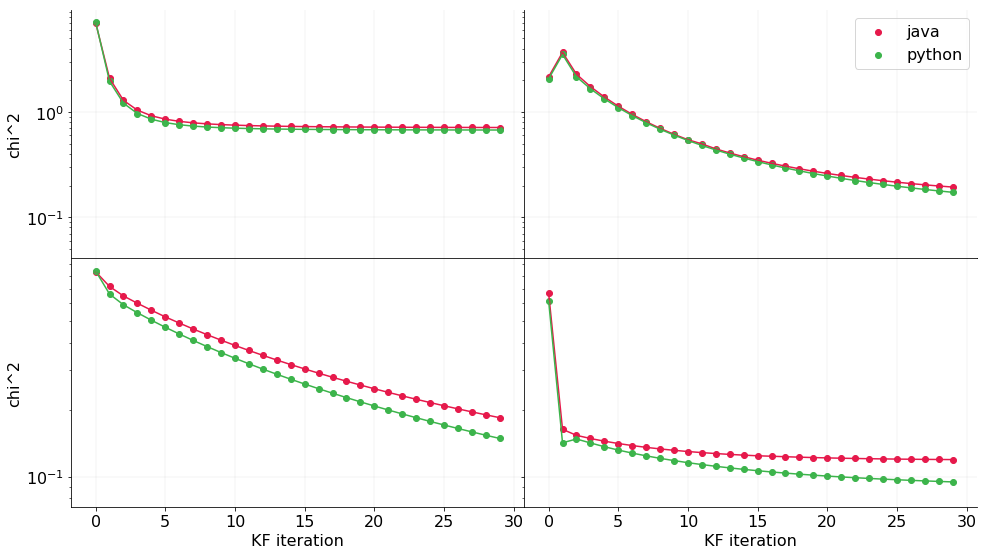

In [44]:
ja_arr = []
py_arr = []
for d in EVENTDIRS:
    ja_arr.append(read_file(MASTERDIR + d + JAVACHI2FILENAME))
    py_arr.append(read_file(MASTERDIR + d + PYTHONCHI2FILENAME))

index = []
for arr in ja_arr:
    index.append(np.arange(len(arr)))

arrlen = math.floor(len(ja_arr)/2)

f, axes = plt.subplots(nrows=arrlen, ncols=2, sharex="col", sharey="row")
f.set_size_inches((14,4*arrlen))

for i in range(0, arrlen*2, 2):
    axes[int(i/2), 0].scatter(index[i],   ja_arr[i],   color=accessibility_95[0], label="java")
    axes[int(i/2), 0].plot(   index[i],   ja_arr[i],   color=accessibility_95[0])
    axes[int(i/2), 0].scatter(index[i],   py_arr[i],   color=accessibility_95[1], label="python")
    axes[int(i/2), 0].plot(   index[i],   py_arr[i],   color=accessibility_95[1])

    axes[int(i/2), 1].scatter(index[i+1], ja_arr[i+1], color=accessibility_95[0], label="java")
    axes[int(i/2), 1].plot(   index[i+1], ja_arr[i+1], color=accessibility_95[0])
    axes[int(i/2), 1].scatter(index[i+1], py_arr[i+1], color=accessibility_95[1], label="python")
    axes[int(i/2), 1].plot(   index[i+1], py_arr[i+1], color=accessibility_95[1])

for i in range(len(axes)):
    axes[i,0].set_ylabel("chi^2")
    for j in range(len(axes[i])):
        axes[i,j].spines['right'].set_visible(False)
        axes[i,j].grid(color=c_gray[0], linestyle='-', linewidth=0.25, alpha=0.5)
        axes[i,j].set_yscale("log")
for j in range(len(axes[0])):
    axes[0,j].spines['top'].set_visible(False)
    axes[1,j].set_xlabel("KF iteration")
axes[0,1].legend()

plt.tight_layout()
f.subplots_adjust(hspace=0, wspace=0)

plt.show()